# Finding the Max Sharpe Ratio Portfolio Based on Given Stocks/Mutual Funds 

SOURCE: Some code used from Investment Management with Python and Machine Learning - EDHEC Business School - Coursera Course (edhec_risk_kit).

We've already seen that given a set of expected returns and a covariance matrix, we can plot the efficient frontier. In this section, we'll extend the code to locate the point on the efficient frontier that we are most interested in, which is the tangency portfolio or the Max Sharpe Ratio portfolio.

This code uses the above objective from the EDHEC Coursera Course and calculates the portfolio weights that returns the Max Sharpe Ratio. Based on the portfolio weights, the code will determine the amount of money to invest in each stock/mutual fund given an amount of money to invest in.

In [75]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as web
import edhec_risk_kit as erk

In [77]:
#Enter stock tickers in tickers list. Example taken from Fastest Growing Stocks from June 2020 (Investopedia)
#Change start and end dates to desired date range.

tickers = ["ABC", "MGM", "ALGN", "DXCM", "NVDA", "AMD"]
multiple_stocks = web.get_data_yahoo(tickers,
start = "2012-01-01",
end = "2020-06-23")
multiple_stocks_monthly_returns = multiple_stocks['Adj Close'].resample('M').ffill().pct_change()


In [78]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


ind = multiple_stocks['Adj Close'].resample('M').ffill().pct_change()
er = erk.annualize_rets(ind, 12)
cov = ind.cov()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
#show monthly returns based on tickers inputted
ind.tail()

Symbols,ABC,ALGN,AMD,DXCM,MGM,NVDA
Date,,,,,,
2020-02-29,-0.010152,-0.150720,-0.032340,0.146417,-0.209272,0.142966
2020-03-31,0.049573,-0.203343,0.000000,-0.024384,-0.515983,-0.023957
2020-04-30,0.013107,0.235125,0.151935,0.244847,0.426271,0.108801
2020-05-31,0.068692,0.143216,0.026914,0.128610,0.020796,0.214657
2020-06-30,0.064611,0.088714,0.003532,0.075573,0.074641,0.065215


In [80]:
#Show annualized returns by stock
er.sort_values(ascending=False)

Symbols
DXCM    0.529753
NVDA    0.478845
ALGN    0.330816
AMD     0.278027
ABC     0.137299
MGM     0.048560
dtype: float64

We already know how to identify points on the curve if we are given a target rate of return. Instead of minimizing the vol based on a target return, we want to find that one point on the curve that maximizes the Sharpe Ratio, given the risk free rate.

```python
def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x
```

Let's guess where the point might be:

(0, 0.1365048278279518)

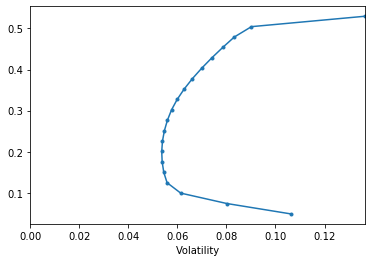

In [81]:
ax = erk.plot_ef(20, er, cov)
ax.set_xlim(left = 0)

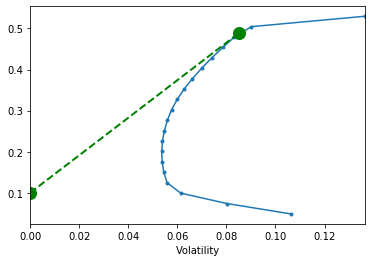

In [82]:
# plot EF
ax = erk.plot_ef(20, er, cov)
ax.set_xlim(left = 0)
# get MSR
rf = 0.1
w_msr = erk.msr(rf, er, cov)
r_msr = erk.portfolio_return(w_msr, er)
vol_msr = erk.portfolio_vol(w_msr, cov)
# add CML
cml_x = [0, vol_msr]
cml_y = [rf, r_msr]
ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)

In [83]:
# get potfolio return, portfolio volatlity
r_msr, vol_msr

(0.4892913006090158, 0.08522151777869484)

Let's put it all together by adding the CML to the `plot_ef` code.

Add the following code:

```python
    if show_cml:
        ax.set_xlim(left = 0)
        # get MSR
        w_msr = msr(riskfree_rate, er, cov)
        r_msr = portfolio_return(w_msr, er)
        vol_msr = portfolio_vol(w_msr, cov)
        # add CML
        cml_x = [0, vol_msr]
        cml_y = [riskfree_rate, r_msr]
        ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)
```


In [84]:
np.around(w_msr, decimals=4, out=None)

array([0.    , 0.0633, 0.    , 0.3891, 0.    , 0.5476])

In [85]:
#Enter amount of money you want to invest. Returns money to invest in for each stock ticker in portfolio.
money_to_invest = 2500
invest_in = list(ind.columns)
portfolio_allocation = np.around(w_msr, decimals=4, out=None) * money_to_invest
dollars = portfolio_allocation.tolist()
invest_in_this = zip(invest_in, dollars)
invest_in_this_set = set(invest_in_this)
invest_in_this_set


{('ABC', 0.0),
 ('ALGN', 158.25),
 ('AMD', 0.0),
 ('DXCM', 972.75),
 ('MGM', 0.0),
 ('NVDA', 1369.0)}